In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

from wordcloud import WordCloud
from nltk import word_tokenize

In [55]:
df = pd.read_csv('data/Mental Health Dataset.csv')

df.head(5)

,posts,predicted,intensity
0,I know as parent of child with down syndrome t...,negative,-1
1,but in my heart I know this is the future prom...,neutral,0
2,I have mylefibrosis which turn to leukemia the...,negative,-1
3,from one of my health group subject wayne dyer...,neutral,0
4,gmos now link to leukemia http nsnbc I 2013 07...,neutral,0


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10392 entries, 0 to 10391
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   posts      10391 non-null  object
 1   predicted  10392 non-null  object
 2   intensity  10392 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 243.7+ KB


In [57]:
#checking nulls
df[df.posts.isna()]

df = df.dropna()

In [58]:
for i in ['predicted', 'intensity']:
    print(df[i].unique())

['negative' 'neutral' 'positive' 'very negative']
[-1  0  1 -2]


In [59]:
# predicted feature just a label of intensity - remove for now

df = df.drop(columns=['intensity'])

df.head(5)

,posts,predicted
0,I know as parent of child with down syndrome t...,negative
1,but in my heart I know this is the future prom...,neutral
2,I have mylefibrosis which turn to leukemia the...,negative
3,from one of my health group subject wayne dyer...,neutral
4,gmos now link to leukemia http nsnbc I 2013 07...,neutral


Text(0, 0.5, 'Frequency')

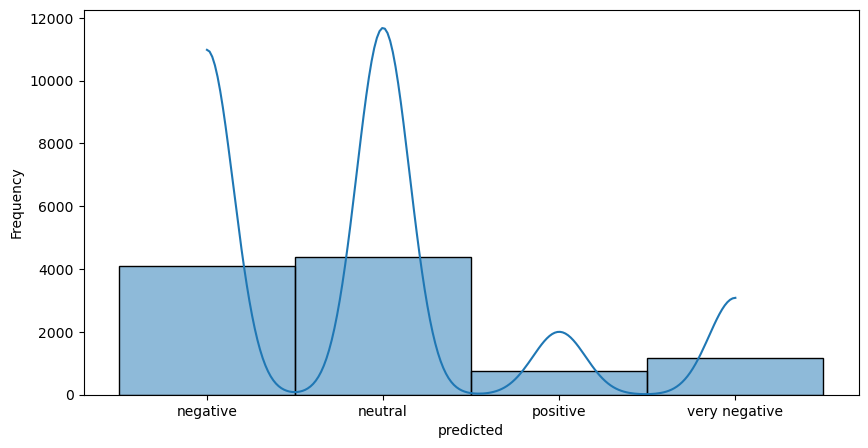

In [60]:
# distribution of intensity

plt.figure(figsize=(10, 5))
sns.histplot(df['predicted'], kde=True)
plt.ylabel('Frequency')

(-0.5, 399.5, 199.5, -0.5)

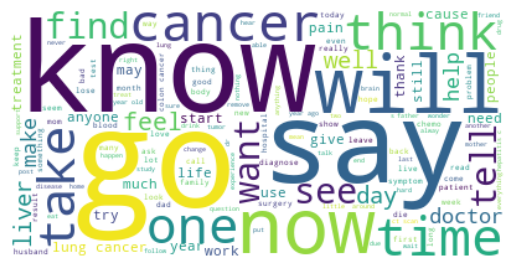

In [61]:
text_for_cloud = ' '.join(df['posts'].dropna())

# cloud
cloud = WordCloud(background_color='white').generate(text_for_cloud)
 
# displaying
plt.imshow(cloud, interpolation='bilinear') 
plt.axis("off")

# Features preparation

In [62]:
#tokens
word_tokens = [word_tokenize(line) for line in df['posts']]

len_tokens = []

# filling up a list with the numbers of the tokens
for i in range(len(word_tokens)):
     len_tokens.append(len(word_tokens[i]))

# adding to df
df['n_words'] = len_tokens

X  = df.drop(columns='predicted')
y = df['predicted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8312, 2)
(8312,)
(2079, 2)
(2079,)


In [63]:
# Vectorizing

stop_words = list(ENGLISH_STOP_WORDS.union(['say', 'go', 'know']))
vect = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 2), max_features=200, token_pattern=r'\b[^\d\W][^\d\W]+\b')


# Fit and transform on training data
X_tr_1 = vect.fit_transform(X_train['posts'])
X_tr_1 = pd.DataFrame(X_tr_1.toarray(), columns=vect.get_feature_names_out())
X_tr_1['n_words'] = X_train['n_words'].reset_index(drop=True)
X_train_init = X_train.copy()
X_train = X_tr_1

# Transform the test data
X_tt_1 = vect.transform(X_test['posts'])
X_tt_1 = pd.DataFrame(X_tt_1.toarray(), columns=vect.get_feature_names_out())
X_tt_1['n_words'] = X_test['n_words'].reset_index(drop=True)
X_test_init = X_test.copy()
X_test = X_tt_1

# Label encoder

enc = LabelEncoder().fit(y)
y_train = pd.Series(enc.transform(y_train))
y_test = pd.Series(enc.transform(y_test))

# Model preparation

In [68]:
# XGB

xgb_model = xgb.XGBClassifier(
    n_estimators=1500,
    learning_rate=0.01,
    max_depth=5,
    reg_alpha=0.01,
    reg_lambda=1,
    objective='multi:softprob',
    random_state=42
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=10,
    verbose=True
)

c:\Users\Oleh\.conda\envs\env001\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.38011
[1]	validation_0-mlogloss:1.37402
[2]	validation_0-mlogloss:1.36800
[3]	validation_0-mlogloss:1.36202
[4]	validation_0-mlogloss:1.35616
[5]	validation_0-mlogloss:1.35034
[6]	validation_0-mlogloss:1.34468
[7]	validation_0-mlogloss:1.33905
[8]	validation_0-mlogloss:1.33349
[9]	validation_0-mlogloss:1.32802
[10]	validation_0-mlogloss:1.32270
[11]	validation_0-mlogloss:1.31744
[12]	validation_0-mlogloss:1.31220
[13]	validation_0-mlogloss:1.30711
[14]	validation_0-mlogloss:1.30210
[15]	validation_0-mlogloss:1.29713
[16]	validation_0-mlogloss:1.29217
[17]	validation_0-mlogloss:1.28736
[18]	validation_0-mlogloss:1.28265
[19]	validation_0-mlogloss:1.27801
[20]	validation_0-mlogloss:1.27336
[21]	validation_0-mlogloss:1.26883
[22]	validation_0-mlogloss:1.26436
[23]	validation_0-mlogloss:1.25992
[24]	validation_0-mlogloss:1.25550
[25]	validation_0-mlogloss:1.25120
[26]	validation_0-mlogloss:1.24694
[27]	validation_0-mlogloss:1.24273
[28]	validation_0-mlogloss:1.2

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [70]:
#XGB evaluation

y_pred_xgb = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_xgb)
print(f'XGB Accuracy: {accuracy:.2f}')

# Print classification report
print('XGB Classification Report:')
print(classification_report(y_test, y_pred_xgb))

XGB Accuracy: 0.68
XGB Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.72      0.67       811
           1       0.75      0.77      0.76       889
           2       0.49      0.14      0.21       133
           3       0.67      0.53      0.59       246

    accuracy                           0.68      2079
   macro avg       0.63      0.54      0.56      2079
weighted avg       0.68      0.68      0.67      2079



In [98]:
# Assuming y_train contains integer labels (0, 1, 2, 3) for the four categories
# Convert them to one-hot encoded labels
y_train_one_hot = to_categorical(y_train, num_classes=4)
y_test_one_hot = to_categorical(y_test, num_classes=4)

# Create the Sequential model
keras_model = Sequential()

# Input layer
keras_model.add(Dense(256, activation='relu', input_dim=X_train.shape[1], name='Input-Dense-Layer'))

# Dropout for regularization
keras_model.add(Dropout(0.33))

# 2nd layer
keras_model.add(Dense(128, activation='relu', name='2nd-Dense-Layer'))

# Dropout for regularization
keras_model.add(Dropout(0.33))

# 3rd layer
keras_model.add(Dense(64, activation='relu', name='3rd-Dense-Layer'))

# Dropout for regularization
keras_model.add(Dropout(0.33))

# Output layer - softmax activation for multi-class classification
keras_model.add(Dense(4, activation='softmax', name='Output-Softmax-Layer'))

# Adam optimizer with learning rate 0.001
optimizer = Adam(learning_rate=0.001)

# Compile the model
keras_model.compile(optimizer=optimizer, 
                    loss='categorical_crossentropy', 
                    metrics=['categorical_accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fitting the model
keras_model.fit(X_train, y_train_one_hot, 
                batch_size=24, 
                epochs=100,
                validation_split=0.2,
                callbacks=[early_stopping],
                verbose=True)


Epoch 1/100
278/278 [==============================] - 3s 7ms/step - loss: 2.5455 - categorical_accuracy: 0.3825 - val_loss: 1.3027 - val_categorical_accuracy: 0.4287
Epoch 2/100
278/278 [==============================] - 2s 6ms/step - loss: 1.3087 - categorical_accuracy: 0.4128 - val_loss: 1.2204 - val_categorical_accuracy: 0.4287
Epoch 3/100
278/278 [==============================] - 2s 7ms/step - loss: 1.2392 - categorical_accuracy: 0.4157 - val_loss: 1.1876 - val_categorical_accuracy: 0.4149
Epoch 4/100
278/278 [==============================] - 2s 7ms/step - loss: 1.2068 - categorical_accuracy: 0.4235 - val_loss: 1.1749 - val_categorical_accuracy: 0.4179
Epoch 5/100
278/278 [==============================] - 2s 6ms/step - loss: 1.1879 - categorical_accuracy: 0.4159 - val_loss: 1.1675 - val_categorical_accuracy: 0.4287
Epoch 6/100
278/278 [==============================] - 2s 6ms/step - loss: 1.1766 - categorical_accuracy: 0.4160 - val_loss: 1.1629 - val_categorical_accuracy: 0.428

In [99]:
#Keras evaluation

y_pred_keras = np.round(keras_model.predict(X_test),0).astype('int')

accuracy = accuracy_score(y_test_one_hot, y_pred_keras)
print(f'XGB Accuracy: {accuracy:.2f}')

# Print classification report
print('XGB Classification Report:')
print(classification_report(y_test_one_hot, y_pred_keras))

65/65 [==============================] - 0s 3ms/step
XGB Accuracy: 0.54
XGB Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       811
           1       0.76      0.71      0.74       889
           2       0.00      0.00      0.00       133
           3       0.00      0.00      0.00       246

   micro avg       0.69      0.54      0.60      2079
   macro avg       0.34      0.33      0.34      2079
weighted avg       0.56      0.54      0.55      2079
 samples avg       0.54      0.54      0.54      2079



c:\Users\Oleh\.conda\envs\env001\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Oleh\.conda\envs\env001\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
